based on https://www.kaggle.com/phoenigs/u-net-dropout-augmentation-stratification/notebook thanks to phoenigs

# Import

In [67]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

import numpy as np
import pandas as pd

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout,Dense,Flatten

import random
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical


from tqdm import tqdm_notebook

# Params and helpers

In [2]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

# Loading of training/testing ids and depths
Reading the training data and the depths, store them in a DataFrame. Also create a test DataFrame with entries from depth not in train.

In [3]:
train_df = pd.read_csv("../input/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../input/depths.csv", index_col="id")
train_df = train_df.join(depths_df)

# Read images and masks
Load the images and masks into the DataFrame and divide the pixel values by 255.

In [4]:
train_df["images"] = [np.array(load_img("../input/train/images/{}.png".format(idx),color_mode='grayscale'))\
                      / 255 for idx in tqdm_notebook(train_df.index)]

In [5]:
train_df["masks"] = [np.array(load_img("../input/train/masks/{}.png".format(idx),color_mode='grayscale')) / 255 for idx in tqdm_notebook(train_df.index)]

# Calculating the salt coverage and salt coverage classes
Counting the number of salt pixels in the masks and dividing them by the image size. Also create 11 coverage classes, -0.1 having no salt at all to 1.0 being salt only.
Plotting the distribution of coverages and coverage classes, and the class against the raw coverage.

In [6]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [36]:
nClasses = 11

def cov_to_class(val):    
    for i in range(0, nClasses):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

Text(0.5, 0, 'Coverage class')

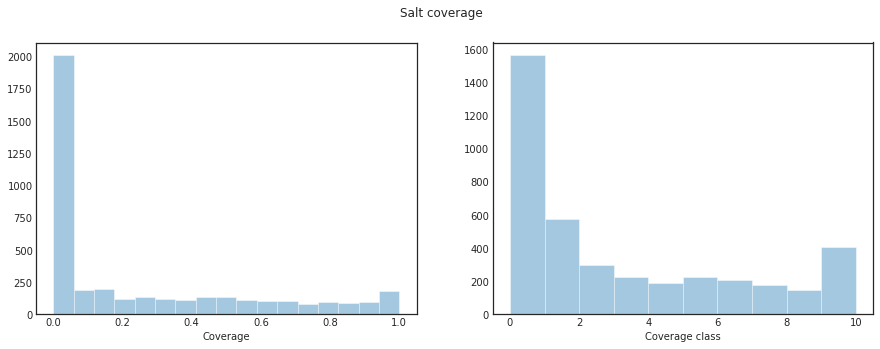

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

# Show some example images

Text(0.5, 0.98, 'Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

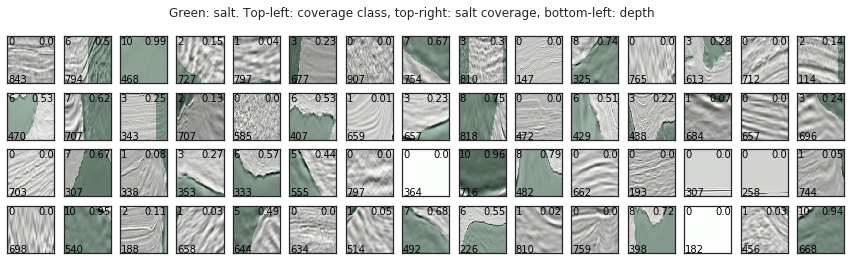

In [38]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

## Bigger images

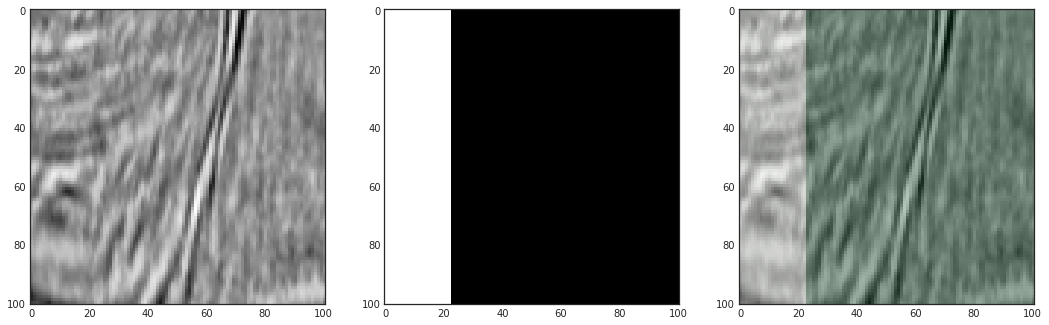

In [30]:
#0.8 salt coverage class

indx = random.choice(train_df[train_df.coverage_class==8].index)
#indx = 'd4acb30303'
img = train_df.loc[indx].images
mask = train_df.loc[indx].masks
_, ax = plt.subplots(nrows=1, 
                     ncols=3, 
                     figsize=(18, 14))
ax[0].imshow(img, cmap="Greys");
ax[1].imshow(mask, cmap="Greys");
ax[2].imshow(img, cmap="Greys")
ax[2].imshow(mask, alpha=0.3, cmap="Greens");

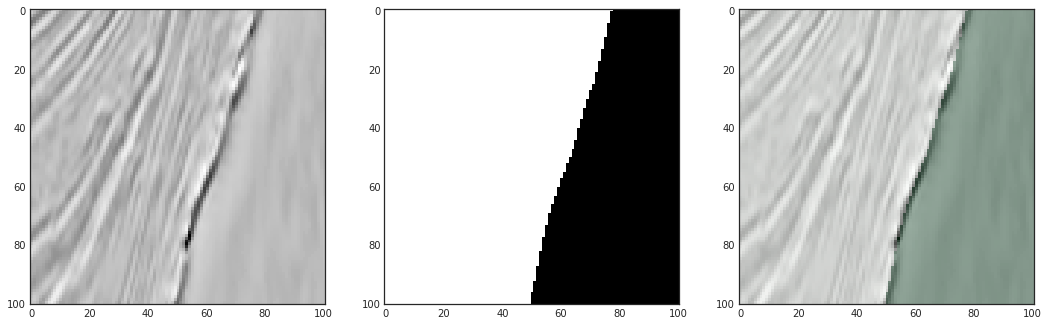

In [31]:
#0.4 salt coverage class

indx = random.choice(train_df[train_df.coverage_class==4].index)
img = train_df.loc[indx].images
mask = train_df.loc[indx].masks
_, ax = plt.subplots(nrows=1, 
                     ncols=3, 
                     figsize=(18, 14))
ax[0].imshow(img, cmap="Greys");
ax[1].imshow(mask, cmap="Greys");
ax[2].imshow(img, cmap="Greys")
ax[2].imshow(mask, alpha=0.3, cmap="Greens");

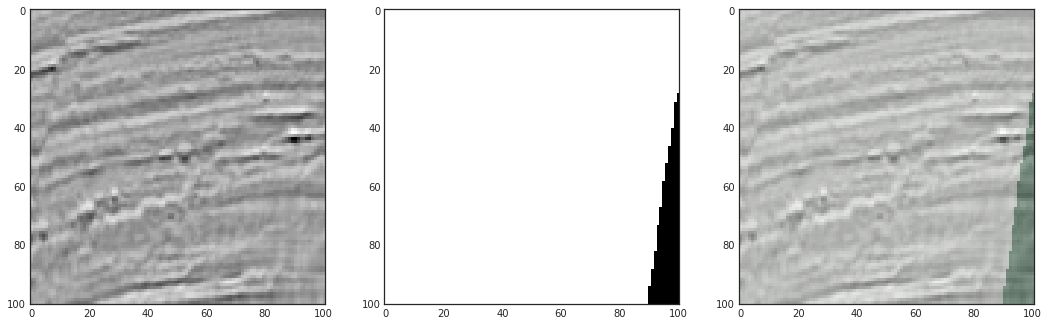

In [32]:
#0.1 salt coverage class

indx = random.choice(train_df[train_df.coverage_class==1].index)
img = train_df.loc[indx].images
mask = train_df.loc[indx].masks
_, ax = plt.subplots(nrows=1, 
                     ncols=3, 
                     figsize=(18, 14))
ax[0].imshow(img, cmap="Greys");
ax[1].imshow(mask, cmap="Greys");
ax[2].imshow(img, cmap="Greys")
ax[2].imshow(mask, alpha=0.3, cmap="Greens");

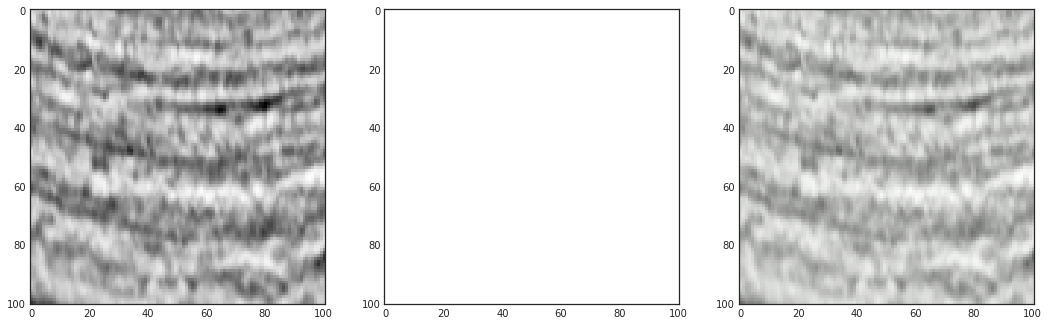

In [33]:
#0.0 salt coverage class

indx = random.choice(train_df[train_df.coverage_class==0].index)
img = train_df.loc[indx].images
mask = train_df.loc[indx].masks
_, ax = plt.subplots(nrows=1, 
                     ncols=3, 
                     figsize=(18, 14))
ax[0].imshow(img, cmap="Greys");
ax[1].imshow(mask, cmap="Greys");
ax[2].imshow(img, cmap="Greys")
ax[2].imshow(mask, alpha=0.3, cmap="Greens");

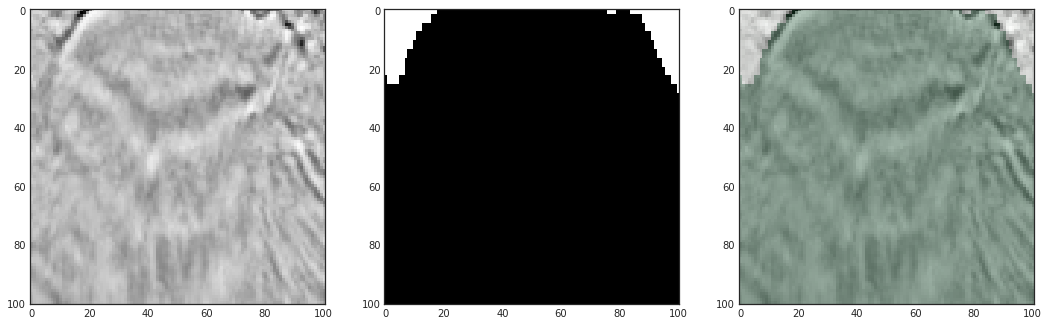

In [34]:
#1.0 salt coverage class

indx = random.choice(train_df[train_df.coverage_class==10].index)
img = train_df.loc[indx].images
mask = train_df.loc[indx].masks
_, ax = plt.subplots(nrows=1, 
                     ncols=3, 
                     figsize=(18, 14))
ax[0].imshow(img, cmap="Greys");
ax[1].imshow(mask, cmap="Greys");
ax[2].imshow(img, cmap="Greys")
ax[2].imshow(mask, alpha=0.3, cmap="Greens");

# Create train/validation split stratified by salt coverage
Using the salt coverage as a stratification criterion. Also show an image to check for correct upsampling.

In [71]:
# one_hot_encoding
target = to_categorical(train_df['coverage_class'])

In [70]:
encoded.shape

(4000, 11)

In [51]:
train_df.head()

,z,images,masks,coverage,coverage_class,target
id,,,,,,
575d24d81d,843,"[[0.5254901960784314, 0.5137254901960784, 0.52...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0,"(-0.001, 0.1]"
a266a2a9df,794,"[[0.3411764705882353, 0.3764705882352941, 0.33...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.504950,6,"(0.5, 0.6]"
75efad62c1,468,"[[0.5686274509803921, 0.4666666666666667, 0.32...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.993334,10,"(0.9, 1.0]"
34e51dba6a,727,"[[0.5411764705882353, 0.4745098039215686, 0.39...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.149201,2,"(0.1, 0.2]"
4875705fb0,797,"[[0.06666666666666667, 0.0784313725490196, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.042839,1,"(-0.001, 0.1]"


In [72]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = \
    train_test_split(
        train_df.index.values,
        np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
        to_categorical(train_df['coverage_class']),  # one_hot_encoding
        train_df.coverage.values,
        train_df.z.values,
        test_size=0.2, stratify=train_df.coverage_class, random_state=1337)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Text(0.5, 1.0, 'Scaled image')

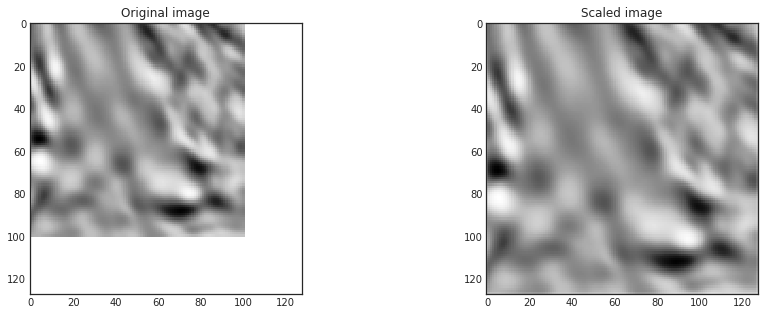

In [40]:
tmp_img = np.zeros((img_size_target, img_size_target), dtype=train_df.images.loc[ids_train[10]].dtype)
tmp_img[:img_size_ori, :img_size_ori] = train_df.images.loc[ids_train[10]]
fix, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].imshow(tmp_img, cmap="Greys")
axs[0].set_title("Original image")
axs[1].imshow(x_train[10].squeeze(), cmap="Greys")
axs[1].set_title("Scaled image")

# Build model

## Convolutional

In [98]:
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    #conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    #pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    #conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    #pool2 = Dropout(0.3)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    #conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    #pool3 = Dropout(0.3)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    #conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    #pool4 = Dropout(0.3)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Dropout(0.3)(convm)
    #convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    flat = Flatten() (convm)
    dens = Dense(512, activation='relu') (flat)
    #dens = Dropout(0.3) (dens)
    output_layer = Dense(nClasses, activation='softmax') (dens)

    return output_layer

input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16)

In [113]:
model = Model(input_layer, output_layer)

In [114]:
model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [115]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 128, 128, 16)      160       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 16, 16, 64)        0         
__________

# Data augmentation

In [47]:
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

Text(0.5, 0.98, 'Top row: original images, bottom row: augmented images')

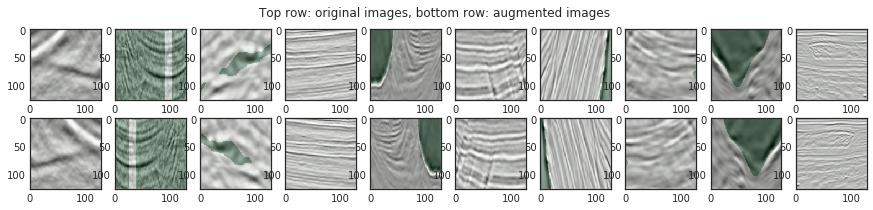

In [48]:
fig, axs = plt.subplots(2, 10, figsize=(15,3))
for i in range(10):
    axs[0][i].imshow(x_train[i].squeeze(), cmap="Greys")
    axs[0][i].imshow(y_train[i].squeeze(), cmap="Greens", alpha=0.3)
    axs[1][i].imshow(x_train[int(len(x_train)/2 + i)].squeeze(), cmap="Greys")
    axs[1][i].imshow(y_train[int(len(y_train)/2 + i)].squeeze(), cmap="Greens", alpha=0.3)
fig.suptitle("Top row: original images, bottom row: augmented images")

Text(0.5, 0.98, 'Top row: original images, bottom row: augmented images')

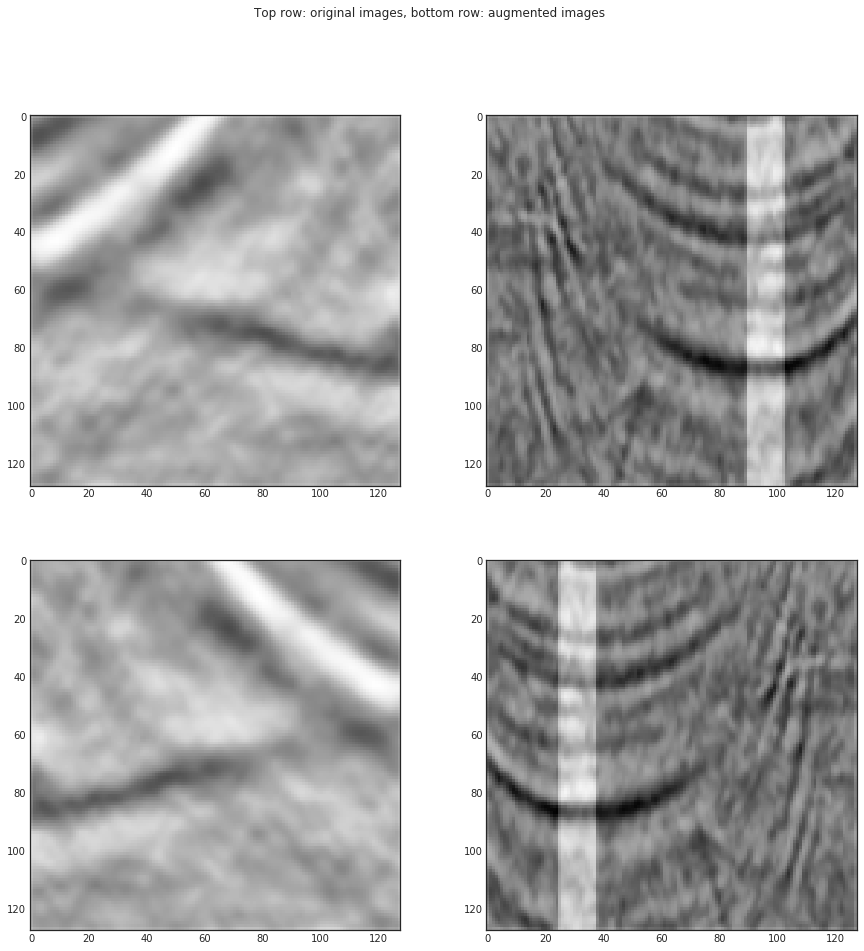

In [49]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))
for i in range(2):
    axs[0][i].imshow(x_train[i].squeeze(), cmap="Greys")
    axs[0][i].imshow(y_train[i].squeeze(), cmap="Greys", alpha=0.3)
    axs[1][i].imshow(x_train[int(len(x_train)/2 + i)].squeeze(), cmap="Greys")
    axs[1][i].imshow(y_train[int(len(y_train)/2 + i)].squeeze(), cmap="Greys", alpha=0.3)
fig.suptitle("Top row: original images, bottom row: augmented images")

# Training

In [120]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

epochs = 10
batch_size = 16

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 3s 930us/step - loss: 0.0162 - acc: 0.9962 - val_loss: 4.2045 - val_acc: 0.5988

Epoch 00001: val_loss improved from inf to 4.20453, saving model to ./keras.model
Epoch 2/10
3200/3200 [==============================] - 3s 928us/step - loss: 0.0013 - acc: 0.9997 - val_loss: 4.2831 - val_acc: 0.5988

Epoch 00002: val_loss did not improve from 4.20453
Epoch 3/10
3200/3200 [==============================] - 3s 887us/step - loss: 0.0015 - acc: 0.9994 - val_loss: 4.4645 - val_acc: 0.6012

Epoch 00003: val_loss did not improve from 4.20453
Epoch 4/10
3200/3200 [==============================] - 3s 916us/step - loss: 0.0015 - acc: 0.9991 - val_loss: 4.3416 - val_acc: 0.5850

Epoch 00004: val_loss did not improve from 4.20453
Epoch 5/10
3200/3200 [==============================] - 3s 907us/step - loss: 0.0014 - acc: 0.9994 - val_loss: 4.4284 - val_acc: 0.5938

Epoch 00005: val_loss did not imp

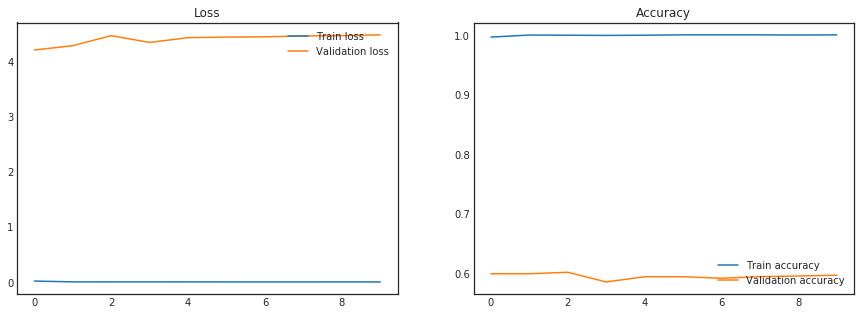

In [121]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.set_title("Loss")
ax_loss.legend(loc='upper right')

ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")
ax_acc.set_title("Accuracy")
ax_acc.legend(loc='lower right')

In [ ]:
model = load_model("./keras.model")

# Predict the validation set to do a sanity check
Again plot some sample images including the predictions.

In [126]:
preds_valid = model.predict(x_valid).argmax(axis=-1)
y_valid_ori = np.array([train_df["coverage_class"].loc[idx] for idx in ids_valid])

In [127]:
preds_valid

array([ 0,  0,  0,  7,  4,  0,  6,  0,  0,  4,  0,  0,  0, 10,  1,  0,  5,
        0,  6,  3,  7,  2,  0,  3,  2,  7,  8,  1,  0,  1, 10,  7,  5,  0,
        6,  0,  1,  0,  0,  1,  0,  0,  2,  2,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  5,  0,  1,  2,  0,  0,  4,  0,  2,  0,  0,  1, 10,  0,
        0,  1,  0,  0,  6,  0,  1,  0,  7,  1,  0,  0,  0, 10,  0,  1,  0,
        0,  8,  0,  0,  1,  0,  0,  1,  6,  5,  1,  1,  1,  0,  0,  0, 10,
        0,  7,  0,  1,  7,  3,  1,  0,  0,  0,  1,  0,  4,  0,  6, 10, 10,
        3,  3,  4,  0,  2,  6,  0,  0,  6,  0,  0, 10,  5,  0, 10,  5,  0,
        0,  4,  0,  0,  6,  7,  7,  0,  0,  0,  5,  0, 10,  0,  0,  2,  0,
        0,  1,  1, 10,  1,  1, 10,  0,  7,  1,  9,  1,  0,  0,  0,  6,  4,
        0,  1,  2,  0,  0,  5, 10,  2,  0,  3,  7,  2,  1,  1,  5, 10,  0,
        0,  0,  0,  5,  3,  0,  3,  0,  0,  3,  3,  1,  9,  1,  0,  3,  0,
        5,  0,  5,  4,  2,  5,  0,  7,  3,  3,  0,  0,  1,  0,  1,  0,  1,
        1,  0,  2, 10,  1

In [125]:
y_valid_ori

array([ 0,  1,  0,  6,  4,  0,  6,  0,  0,  5,  0,  8,  0, 10,  0,  0,  5,
        8,  7,  3,  6,  3,  9,  4,  2,  6,  5,  1,  2,  0,  0,  2,  2,  1,
        5,  1,  1,  2,  0,  1,  0,  1,  2,  4,  0,  0,  0,  0,  0,  1,  0,
        0,  1,  0,  5,  0,  1,  4,  0,  0,  6,  0,  4,  0,  0,  1,  0,  0,
        0,  2,  8,  0,  6,  0,  1,  1,  7,  0,  0,  0,  0,  7, 10,  1,  0,
        0,  8,  0,  0,  2,  0,  0,  1,  6,  5,  1,  0,  0,  1,  3,  0, 10,
        0,  6,  1,  1,  8,  4, 10,  0,  0,  0,  2, 10,  4,  5,  3, 10, 10,
        3,  3,  4,  0,  2,  6,  0,  0,  7,  0,  0,  8,  5,  1, 10,  5,  0,
        2,  5,  0,  2,  9,  7,  8,  0,  2,  0,  4,  0, 10,  0,  0,  1,  2,
        1,  1,  0,  5,  1,  1, 10,  0,  7,  0, 10,  2,  0,  0,  0,  6,  4,
        0,  2,  2,  0,  0,  8, 10,  3,  0,  1,  8,  1,  1,  2,  5, 10,  0,
        0,  0,  0,  5,  3,  0,  3,  0,  0,  0,  5,  0,  5,  0,  0,  2,  3,
        6,  0,  5,  5,  2,  5,  2,  6,  3,  1,  0,  0,  1,  0,  1,  0,  1,
        1,  5,  2, 10,  2

In [ ]:
fig, axs = plt.subplots(2, 10, figsize=(15,3))
for i in range(10):
    axs[0][i].imshow(x_train[i].squeeze(), cmap="Greys")
    axs[0][i].imshow(y_train[i].squeeze(), cmap="Greens", alpha=0.3)
    axs[1][i].imshow(x_train[int(len(x_train)/2 + i)].squeeze(), cmap="Greys")
    axs[1][i].imshow(y_train[int(len(y_train)/2 + i)].squeeze(), cmap="Greens", alpha=0.3)
fig.suptitle("Top row: original images, bottom row: augmented images")

Text(0.5, 0.98, 'Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

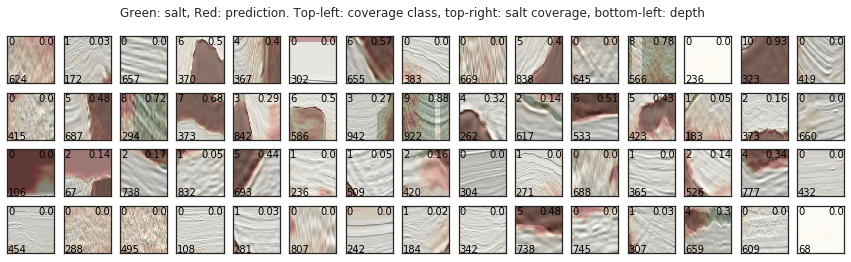

In [26]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(pred, alpha=0.3, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")